## Christian Mandelli - Highly Efficient siRNAs Prediction 

### Problem Description
#### URL: url of the review once it will be published
Then, the selection of an effective siRNA sequence for optimized systemic silencing remains a major bottleneck for potential applications RNAi-based products in the field (Dalakouras et al., 2018, Schwartz et al., 2020, Hendrix et al., 2021). The role of 22nt siRNA in triggering a systemic RNAi in the whole plant is well documented and requires the action of the RDR6 polymerase that is likely responsible for the amplification, the transitivity, and the systemic spread of RNAi (McHale et al., 2013, Taochy et al., 2017, Chen et al., 2018). However, the recruitment of RDR6 can occur with any-sized sRNA that contains an asymmetric bulge in its duplex structure (Manavella et al., 2012; Dalakouras et al., 2016, 2018). In this context, coupling the increasing genomic resources for fruit trees to the development of robust in silico tools to predict siRNAs species with high silencing efficiency with a systemic potential is a significant priority. Algorithms like Support Vector Machines (SVM) can be trained and tested over a sequence dataset, which has already been experimentally validated. Once the best prediction parameters are set up, they can be used to predict siRNAs from long dsRNA sequences. Sequence composition features have historically represented most of the critical features used in the SVM pipeline as di- and tri-nucleotide counts, global and local GC content, duplex flexibility, and thermodynamics stability (Sciabola et al., 2021; Shabalina et al., 2006). But recent studies have demonstrated the pivotal role of the target accessibility and siRNA 5’ composition for incorporating into the Argonaute (AGO) protein active site as essential criteria to assess the silencing property of the siRNA sequence (Gago-Zachert, 2019). 
Recently developed  in silico tools have strategized a hybrid-SVM-based prediction based on efficacy scores from previously designed models (nonspecific and toxic siRNAs removal, intended versus unintended target transcripts, RISC loading efficacy of the siRNA, target site accessibility, highly specific siRNA) combined with training datasets (siRNA) that had empirically demonstrated efficacious systemic silencing of predicted siRNA (Ahmed et al., 2020). A correlation coefficient greater than 0.7 between the measured and predicted efficacy of the siRNA candidate was observed, here we are trying to do best.

### Adopted Strategies:
#### Strategy 1
I will classify the siRNAs as potent or not, by using the features provided by Huesken, 2005 (https://doi.org/10.1038/nbt1118), through the application of an SVM algorithm and by pre-processing the data through One-Hot Encoding. Potency thresholding is set at 70% of silencing compared to the control.
#### Strategy 2
Strategy 1 but with Label Encoding
#### Strategy 3
I will only use the dataset for running a Neural Networks classification, after pre-processing through One-Hot Encoding.

### Install Packages and Modules

In [3]:
%%sh
pip install gffutils # https://pythonhosted.org/pyfaidx/
pip install pyfaidx # https://pythonhosted.org/gffutils/contents.html
pip install biopython

### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import gffutils
import pyfaidx

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.metrics import *

### Python Analysis

In [2]:
# Notebook specific behavior setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = 10

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot")

### Load Data
#### The dataset provided by the previous authors needed to be processed through a custom "features extractor" in order to obtain a dataframe readable by SVM.

In [4]:
data = "siRNA_features_70.csv"

In [5]:
#I'm creating a first general dataframe common to every strategy in order to clean it and perfor some check, before creating every single df for each strategy
df1 = pd.read_csv(data)
df1

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
0,C,U,A,A,U,...,46.45,1.5,CUAAUAU,GAUUUAU,0.0
1,A,A,U,A,U,...,46.80,0.6,AAUAUGU,UUUAUAC,0.0
2,G,A,U,U,U,...,53.21,-1.6,GAUUUAU,CUUUCAA,0.0
3,C,A,A,U,U,...,52.19,0.7,CAAUUCC,UUUAUCU,0.0
4,C,A,G,A,C,...,52.69,2.9,CAGACCA,AUAAGAA,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2423,A,A,A,A,C,...,66.66,-1.5,AAAACCC,AAAGUAG,1.0
2424,G,A,U,G,A,...,64.48,-2.4,GAUGAUC,GAACUAC,1.0
2425,A,U,C,A,G,...,67.66,-3.3,AUCAGAA,UACUCGG,1.0
2426,G,A,A,G,C,...,67.90,0.3,GAAGCUG,CGGUUGA,0.0


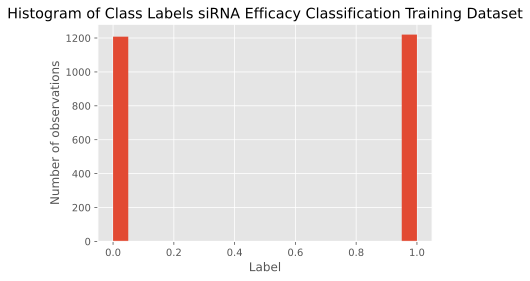

In [6]:
#Create an histogram for the original dataset to check positive and negative examples distribution
df1["Label"].hist(bins=20);
#Add a title and axis labels
plt.title("Histogram of Class Labels siRNA Efficacy Classification Training Dataset");
plt.xlabel("Label");
plt.ylabel("Number of observations");

### Even if the distribution is good, we can still balance the dataset depending on the classes just for perfectionism

In [7]:
df_balanced0 = df1.query("Label == 0").sample(n=1200)
df_balanced1 = df1.query("Label == 1").sample(n=1200)

df = pd.concat([df_balanced0, df_balanced1], axis=0)
df

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1356,G,U,U,C,U,...,66.91,1.3,GUUCUGU,UCUCCUG,0.0
524,G,A,U,G,U,...,70.26,-1.2,GAUGUAC,AGGUGUC,0.0
2172,C,C,C,G,G,...,70.63,-0.1,CCCGGUU,UUGUUGU,0.0
2284,C,C,U,G,A,...,71.54,-6.1,CCUGACA,GGGCAGA,0.0
803,C,A,C,U,C,...,69.98,-1.0,CACUCCC,GAGGUUC,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2221,U,A,A,C,U,...,69.11,2.2,UAACUUC,GCUUCUU,1.0
2012,G,U,G,A,G,...,78.58,-5.5,GUGAGCA,CGAGGCC,1.0
357,A,C,U,G,G,...,71.71,-4.4,ACUGGAA,UCCGUGA,1.0
1522,A,G,A,A,A,...,63.45,0.4,AGAAAUG,CACCAUU,1.0


In [8]:
# Check for Not Null elements in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 1356 to 2097
Data columns (total 61 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   P1               2400 non-null   object 
 1   P2               2400 non-null   object 
 2   P3               2400 non-null   object 
 3   P4               2400 non-null   object 
 4   P5               2400 non-null   object 
 5   P6               2400 non-null   object 
 6   P7               2400 non-null   object 
 7   P8               2400 non-null   object 
 8   P9               2400 non-null   object 
 9   P10              2400 non-null   object 
 10  P11              2400 non-null   object 
 11  P12              2400 non-null   object 
 12  P13              2400 non-null   object 
 13  P14              2400 non-null   object 
 14  P15              2400 non-null   object 
 15  P16              2400 non-null   object 
 16  P17              2400 non-null   object 
 17  P18        

In [9]:
# Check for Global_ΔG values since it was the column with problems
df["Global_ΔG"].value_counts()

-1.0     63
 0.3     51
-0.5     51
-0.3     45
-2.3     42
         ..
-9.1      1
-13.3     1
-11.4     1
-14.3     1
-10.3     1
Name: Global_ΔG, Length: 162, dtype: int64

In [10]:
#I checked and from row 210 there are some rows with 1600 in the ΔG column, that must be deleted since it's an error
#remove rows using the drop() function
df.drop(df.index[df['Global_ΔG'] > 100.0], inplace=True)
# display the dataframe
df

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1356,G,U,U,C,U,...,66.91,1.3,GUUCUGU,UCUCCUG,0.0
524,G,A,U,G,U,...,70.26,-1.2,GAUGUAC,AGGUGUC,0.0
2172,C,C,C,G,G,...,70.63,-0.1,CCCGGUU,UUGUUGU,0.0
2284,C,C,U,G,A,...,71.54,-6.1,CCUGACA,GGGCAGA,0.0
803,C,A,C,U,C,...,69.98,-1.0,CACUCCC,GAGGUUC,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2221,U,A,A,C,U,...,69.11,2.2,UAACUUC,GCUUCUU,1.0
2012,G,U,G,A,G,...,78.58,-5.5,GUGAGCA,CGAGGCC,1.0
357,A,C,U,G,G,...,71.71,-4.4,ACUGGAA,UCCGUGA,1.0
1522,A,G,A,A,A,...,63.45,0.4,AGAAAUG,CACCAUU,1.0


In [10]:
#df.drop(df.index[df['Global_ΔG'] == 'inf'], inplace=True)
#df

In [11]:
#outputfile='/Users/christian/Desktop/siRNA ML/siRNA_features_filtered.csv'
#df.to_csv(outputfile,index=False)

In [12]:
#Rename columns (optional)
#df.columns = ["Patient_ID", "Response", "PR_Seq", "RT_Seq", "VL_T0", "CD4_T0"]

In [13]:
#Move the outcome (Response) column at the last column position of the dataset (optional)
#df = df[["Patient_ID", "PR_Seq", "RT_Seq", "VL_T0", "CD4_T0","Response"]]

In [14]:
#Columns check
df.head()

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1417,C,A,U,C,A,...,59.43,-0.4,CAUCAUU,GGAUCAU,0.0
597,C,U,U,A,A,...,63.78,-1.1,CUUAAGA,AGGAAUG,0.0
1010,A,U,A,U,A,...,60.12,2.6,AUAUACC,UCCAAAC,0.0
537,C,G,U,A,G,...,72.37,-0.5,CGUAGGA,GGGGAGC,0.0
898,C,U,U,C,G,...,64.16,0.3,CUUCGGC,CUGAACA,0.0


In [15]:
#Check for NAs
pd.isna(df)

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1417,False,False,False,False,False,...,False,False,False,False,False
597,False,False,False,False,False,...,False,False,False,False,False
1010,False,False,False,False,False,...,False,False,False,False,False
537,False,False,False,False,False,...,False,False,False,False,False
898,False,False,False,False,False,...,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
983,False,False,False,False,False,...,False,False,False,False,False
52,False,False,False,False,False,...,False,False,False,False,False
1104,False,False,False,False,False,...,False,False,False,False,False
1800,False,False,False,False,False,...,False,False,False,False,False


In [11]:
#If there are some NAs, those rows need to be deleted
df = df.dropna()
df

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1356,G,U,U,C,U,...,66.91,1.3,GUUCUGU,UCUCCUG,0.0
524,G,A,U,G,U,...,70.26,-1.2,GAUGUAC,AGGUGUC,0.0
2172,C,C,C,G,G,...,70.63,-0.1,CCCGGUU,UUGUUGU,0.0
2284,C,C,U,G,A,...,71.54,-6.1,CCUGACA,GGGCAGA,0.0
803,C,A,C,U,C,...,69.98,-1.0,CACUCCC,GAGGUUC,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2221,U,A,A,C,U,...,69.11,2.2,UAACUUC,GCUUCUU,1.0
2012,G,U,G,A,G,...,78.58,-5.5,GUGAGCA,CGAGGCC,1.0
357,A,C,U,G,G,...,71.71,-4.4,ACUGGAA,UCCGUGA,1.0
1522,A,G,A,A,A,...,63.45,0.4,AGAAAUG,CACCAUU,1.0


### Now that NaN rows have been excluded from the dataset, it is possible to proceed witht the Encoding preprocessing step in order to transform nucleotide and amino acid sequences in dummies
#### Import Packages

In [12]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import OneHotEncoder
import re

### Peform One-Hot Encoding, for which data must be transformed into an array.
#### One need to pre-process the data outsite the dataset (to my knowledge). Once encoded, new column could be concatenated to the old dataset and the old ones containing raw data could be removed.

In [13]:
#One-Hot Encoding for the two features that are sequences, for both dataframes 
ohe = OneHotEncoder()
RT_OHE1 = pd.DataFrame(ohe.fit_transform(df1[['RT_Seq']]).toarray())
PR_OHE1 = pd.DataFrame(ohe.fit_transform(df1[['PR_Seq']]).toarray())

RT_OHE2 = pd.DataFrame(ohe.fit_transform(df2[['RT']]).toarray())
PR_OHE2 = pd.DataFrame(ohe.fit_transform(df2[['PR']]).toarray())

RT_OHE1
PR_OHE1

RT_OHE2
PR_OHE2

,0,1,2,3,4,...,915,916,917,918,919
0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
916,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
917,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
918,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,...,915,916,917,918,919
0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0
916,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0
917,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0
918,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0


,0,1,2,3,4,...,915,916,917,918,919
0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
916,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
917,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
918,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,...,893,894,895,896,897
0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0
916,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
917,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0
918,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0


In [14]:
#Concatenate old dataset to new encoded columns
#From now, df1 and df2 will be kept as common dataframes, and I'm creating df1ohe and df2ohe as dataset with OneHot Encoded Features
df1ohe = pd.concat([df1, RT_OHE1, PR_OHE1], axis=1)
df2ohe = pd.concat([df2, RT_OHE2, PR_OHE2], axis=1)

df1
df1ohe
df2
df2ohe

,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
0,1,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145,0
1,2,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224,0
2,3,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017,0
3,4,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206,0
4,5,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572,0
...,...,...,...,...,...,...
915,916,GTCACAGTAAAAGTAGAGGGGCAACTAAAAGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,5.5,438,0
916,917,GTCGCAGTAAAGRTAGGGGGACAGCTAAAGGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,3.7,279,0
917,918,NCTCANATCACTCTTTGGCAACGACCCATCGTCACAATAAAGATAG...,CCCATTAGTCCTATTAAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.1,263,0
918,919,RTAAAGATRGGGGGACAACTAAAGGAAGCTTTATTAGATACAGGAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCGGGAA...,5.6,5,1


,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,...,915,916,917,918,919
0,1,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145,...,0.0,0.0,0.0,0.0,0.0
1,2,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224,...,0.0,0.0,0.0,0.0,0.0
2,3,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017,...,0.0,0.0,0.0,0.0,0.0
3,4,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206,...,0.0,0.0,0.0,0.0,0.0
4,5,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,916,GTCACAGTAAAAGTAGAGGGGCAACTAAAAGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,5.5,438,...,1.0,0.0,0.0,0.0,0.0
916,917,GTCGCAGTAAAGRTAGGGGGACAGCTAAAGGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,3.7,279,...,0.0,1.0,0.0,0.0,0.0
917,918,NCTCANATCACTCTTTGGCAACGACCCATCGTCACAATAAAGATAG...,CCCATTAGTCCTATTAAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.1,263,...,0.0,0.0,1.0,0.0,0.0
918,919,RTAAAGATRGGGGGACAACTAAAGGAAGCTTTATTAGATACAGGAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCGGGAA...,5.6,5,...,0.0,0.0,0.0,1.0,0.0


,Patient_ID,PR,RT,VL_T0,CD4_T0,Response
0,1,PQITLWQRPLVPIRIGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,4.3,145,0
1,2,PQITLWQRPLVAIKIGGQLKEALLDTGADDTVLEDMELPGRWKPKI...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEXEGK...,3.6,224,0
2,3,PQITLWQRPLVAIKVGGQLKEALLDTGADDTVLEDMSLPGKWKPKM...,PISPIETVPVKLKPGMDGPXVKQWPLTEEKIKALVEICTELEKEGK...,3.2,1017,0
3,4,PQITLWQRPLVAIRIGGQLKEALLDTGADDTVLEDMNLPGKWKPKM...,PISPIETVPVKLKPGMDGPKIKQWPLTEEKIKALVEICTEMEKEGK...,5.7,206,0
4,5,PQITLWQRPLVAVKIGGQLKEALLDTGADDTVLEEMTLPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVXICTEMEKEGK...,3.5,572,0
...,...,...,...,...,...,...
915,916,VTVKVEGQLKEALLDTGADNTVLEEXNLPGRWKPKMIGGIGGFIKV...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICSELEKDGK...,5.5,438,0
916,917,VAVKXGGQLKEALLDTGADDTVLEDMTLPGRWKPKMIGGIGGFIKV...,PISPIETVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTEMEKEGK...,3.7,279,0
917,918,XXITLWQRPIVTIKIGGQLREALLDTGADDTVFEDINLPGRWKPKX...,PISPIKTVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTELEQDGK...,4.1,263,0
918,919,XKXGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQ...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,5.6,5,1


,Patient_ID,PR,RT,VL_T0,CD4_T0,...,893,894,895,896,897
0,1,PQITLWQRPLVPIRIGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,4.3,145,...,0.0,0.0,0.0,0.0,0.0
1,2,PQITLWQRPLVAIKIGGQLKEALLDTGADDTVLEDMELPGRWKPKI...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEXEGK...,3.6,224,...,0.0,0.0,0.0,0.0,0.0
2,3,PQITLWQRPLVAIKVGGQLKEALLDTGADDTVLEDMSLPGKWKPKM...,PISPIETVPVKLKPGMDGPXVKQWPLTEEKIKALVEICTELEKEGK...,3.2,1017,...,0.0,0.0,0.0,0.0,0.0
3,4,PQITLWQRPLVAIRIGGQLKEALLDTGADDTVLEDMNLPGKWKPKM...,PISPIETVPVKLKPGMDGPKIKQWPLTEEKIKALVEICTEMEKEGK...,5.7,206,...,0.0,0.0,0.0,0.0,0.0
4,5,PQITLWQRPLVAVKIGGQLKEALLDTGADDTVLEEMTLPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVXICTEMEKEGK...,3.5,572,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,916,VTVKVEGQLKEALLDTGADNTVLEEXNLPGRWKPKMIGGIGGFIKV...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICSELEKDGK...,5.5,438,...,0.0,0.0,1.0,0.0,0.0
916,917,VAVKXGGQLKEALLDTGADDTVLEDMTLPGRWKPKMIGGIGGFIKV...,PISPIETVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTEMEKEGK...,3.7,279,...,0.0,0.0,0.0,0.0,0.0
917,918,XXITLWQRPIVTIKIGGQLREALLDTGADDTVFEDINLPGRWKPKX...,PISPIKTVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTELEQDGK...,4.1,263,...,0.0,0.0,0.0,0.0,1.0
918,919,XKXGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQ...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,5.6,5,...,0.0,0.0,0.0,1.0,0.0


In [15]:
#Remove old columns containing raw/discrete data/variables which are not suitable for ML algorithm
df1ohe = df1ohe.drop(['RT_Seq', 'PR_Seq'], 1)
df2ohe = df2ohe.drop(['RT', 'PR'], 1)

df1
df1ohe
df2
df2ohe

/tmp/ipykernel_3052/3022646198.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1ohe = df1ohe.drop(['RT_Seq', 'PR_Seq'], 1)
/tmp/ipykernel_3052/3022646198.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df2ohe = df2ohe.drop(['RT', 'PR'], 1)


,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
0,1,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145,0
1,2,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224,0
2,3,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017,0
3,4,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206,0
4,5,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572,0
...,...,...,...,...,...,...
915,916,GTCACAGTAAAAGTAGAGGGGCAACTAAAAGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,5.5,438,0
916,917,GTCGCAGTAAAGRTAGGGGGACAGCTAAAGGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,3.7,279,0
917,918,NCTCANATCACTCTTTGGCAACGACCCATCGTCACAATAAAGATAG...,CCCATTAGTCCTATTAAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.1,263,0
918,919,RTAAAGATRGGGGGACAACTAAAGGAAGCTTTATTAGATACAGGAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCGGGAA...,5.6,5,1


,Patient_ID,VL_T0,CD4_T0,Response,0,...,915,916,917,918,919
0,1,4.3,145,0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,2,3.6,224,0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,3,3.2,1017,0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,4,5.7,206,0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,5,3.5,572,0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,916,5.5,438,0,0.0,...,1.0,0.0,0.0,0.0,0.0
916,917,3.7,279,0,0.0,...,0.0,1.0,0.0,0.0,0.0
917,918,4.1,263,0,0.0,...,0.0,0.0,1.0,0.0,0.0
918,919,5.6,5,1,0.0,...,0.0,0.0,0.0,1.0,0.0


,Patient_ID,PR,RT,VL_T0,CD4_T0,Response
0,1,PQITLWQRPLVPIRIGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,4.3,145,0
1,2,PQITLWQRPLVAIKIGGQLKEALLDTGADDTVLEDMELPGRWKPKI...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEXEGK...,3.6,224,0
2,3,PQITLWQRPLVAIKVGGQLKEALLDTGADDTVLEDMSLPGKWKPKM...,PISPIETVPVKLKPGMDGPXVKQWPLTEEKIKALVEICTELEKEGK...,3.2,1017,0
3,4,PQITLWQRPLVAIRIGGQLKEALLDTGADDTVLEDMNLPGKWKPKM...,PISPIETVPVKLKPGMDGPKIKQWPLTEEKIKALVEICTEMEKEGK...,5.7,206,0
4,5,PQITLWQRPLVAVKIGGQLKEALLDTGADDTVLEEMTLPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVXICTEMEKEGK...,3.5,572,0
...,...,...,...,...,...,...
915,916,VTVKVEGQLKEALLDTGADNTVLEEXNLPGRWKPKMIGGIGGFIKV...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICSELEKDGK...,5.5,438,0
916,917,VAVKXGGQLKEALLDTGADDTVLEDMTLPGRWKPKMIGGIGGFIKV...,PISPIETVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTEMEKEGK...,3.7,279,0
917,918,XXITLWQRPIVTIKIGGQLREALLDTGADDTVFEDINLPGRWKPKX...,PISPIKTVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTELEQDGK...,4.1,263,0
918,919,XKXGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQ...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,5.6,5,1


,Patient_ID,VL_T0,CD4_T0,Response,0,...,893,894,895,896,897
0,1,4.3,145,0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,2,3.6,224,0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,3,3.2,1017,0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,4,5.7,206,0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,5,3.5,572,0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
915,916,5.5,438,0,0.0,...,0.0,0.0,1.0,0.0,0.0
916,917,3.7,279,0,0.0,...,0.0,0.0,0.0,0.0,0.0
917,918,4.1,263,0,0.0,...,0.0,0.0,0.0,0.0,1.0
918,919,5.6,5,1,0.0,...,0.0,0.0,0.0,1.0,0.0


### Crossvalidation on OneHot Encoded Nuc-based Datasets for Strategy 1

In [16]:
# Split up dataset into 80% crossvalidation, 20% independent held-out test data
# Documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
df1ohe_crossval, df1ohe_test, class_crossval1ohe, class_test1ohe = train_test_split(
    df1ohe[[c for c in df1ohe.columns if c != "Response"]], 
    df1ohe["Response"], 
    test_size=0.20,
    stratify=df1ohe["Response"],
    random_state=42  # sets seed to make the selection reproducible
)

# Check output to ensure split is as intended
df1ohe_crossval.shape, df1ohe_test.shape, class_crossval1ohe.shape, class_test1ohe.shape

((736, 3683), (184, 3683), (736,), (184,))

In [17]:
# Set indices in ascending order starting from 0
#  as required by the sci-kit learn's StratifiedKFold function
df1ohe_crossval.reset_index(inplace = True)
class_crossval1ohe = class_crossval1ohe.reset_index()

# If one wanted to recover the original indices:
# df_crossval.set_index("index")

In [18]:
# Prepare crossvalidation set
#   Documentation at https://scikit-learn.org/stable/modules/cross_validation.html#stratification
n_partitions = 5
skf = StratifiedKFold(n_splits = n_partitions)

# Split into crossvalidation sets (sets of indices in df_crossval and class_crossval)
#  and print out the resulting partition compositions for each partition as
#  train - [num_of_items_in_class_0 num_of_items_in_class_1] | test - [num_of_items_in_class_0 num_of_items_in_class_1]
y = class_crossval1ohe["Response"]  # This line is needed for the np.bincount function to work
for train, test in skf.split(df1ohe_crossval, y):
    print(f"train - {np.bincount(y[train])} | test - {np.bincount(y[test])}")

train - [468 120] | test - [118  30]
train - [469 120] | test - [117  30]
train - [469 120] | test - [117  30]
train - [469 120] | test - [117  30]
train - [469 120] | test - [117  30]


### Crossvalitation on OneHot Encoded Protein Based Dataset for Strategy 1

In [19]:
# Split up dataset into 80% crossvalidation, 20% independent held-out test data
# Documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
df2ohe_crossval, df2ohe_test, class_crossval2ohe, class_test2ohe = train_test_split(
    df2ohe[[c for c in df2ohe.columns if c != "Response"]], 
    df2ohe["Response"], 
    test_size=0.20,
    stratify=df2ohe["Response"],
    random_state=42  # sets seed to make the selection reproducible
)

# Check output to ensure split is as intended
df2ohe_crossval.shape, df2ohe_test.shape, class_crossval2ohe.shape, class_test2ohe.shape

((736, 3617), (184, 3617), (736,), (184,))

In [20]:
# Set indices in ascending order starting from 0
#  as required by the sci-kit learn's StratifiedKFold function
df2ohe_crossval.reset_index(inplace = True)
class_crossval2ohe = class_crossval2ohe.reset_index()

# If one wanted to recover the original indices:
# df_crossval.set_index("index")

In [21]:
# Prepare crossvalidation set
#   Documentation at https://scikit-learn.org/stable/modules/cross_validation.html#stratification
n_partitions = 5
skf = StratifiedKFold(n_splits = n_partitions)

# Split into crossvalidation sets (sets of indices in df_crossval and class_crossval)
#  and print out the resulting partition compositions for each partition as
#  train - [num_of_items_in_class_0 num_of_items_in_class_1] | test - [num_of_items_in_class_0 num_of_items_in_class_1]
y = class_crossval2ohe["Response"]  # This line is needed for the np.bincount function to work
for train, test in skf.split(df2ohe_crossval, y):
    print(f"train - {np.bincount(y[train])} | test - {np.bincount(y[test])}")

train - [468 120] | test - [118  30]
train - [469 120] | test - [117  30]
train - [469 120] | test - [117  30]
train - [469 120] | test - [117  30]
train - [469 120] | test - [117  30]


### Application of SVM Classifier to the Strategy 1 Datasets

In [22]:
%%capture
# Apply an SVM classifier to the nucleotide dataset
#  Documentation at https://scikit-learn.org/stable/modules/svm.html
#   and at https://scikit-learn.org/stable/modules/cross_validation.html
clf1ohe = svm.SVC(kernel='linear', C=1, random_state=42)  # define classifier
scores1ohe = cross_validate(clf1ohe, df1ohe_crossval, class_crossval1ohe["Response"], cv=skf,
    scoring = ('accuracy', 'precision'),
    return_train_score=True)
# Other scikit-learn classifiers of possible interest:
#
# Logistic Regression with linear_model.LogisticRegression
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# Decision Tree based classification with tree.DecisionTreeClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#
# Neural Network based classification with neural_network.MLPClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html



In [23]:
%%capture
# Apply an SVM classifier to the protein dataset
#  Documentation at https://scikit-learn.org/stable/modules/svm.html
#   and at https://scikit-learn.org/stable/modules/cross_validation.html
clf2ohe = svm.SVC(kernel='linear', C=1, random_state=42)  # define classifier
scores2ohe = cross_validate(clf2ohe, df2ohe_crossval, class_crossval2ohe["Response"], cv=skf,
    scoring = ('accuracy', 'precision'),
    return_train_score=True)

In [24]:
# Examine results
scores1ohe

# Nicer printing of specific performance metrics across partitions
scores_train_acc1ohe = scores1ohe["train_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc1ohe]) + '%')

scores_train_acc1ohe = scores1ohe["test_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc1ohe]) + '%')

{'fit_time': array([127.47187066, 138.2525692 , 101.52547836, 122.25146365,
        143.4503274 ]),
 'score_time': array([0.14925838, 0.16367507, 0.14516664, 0.14609408, 0.15415144]),
 'test_accuracy': array([0.78378378, 0.83673469, 0.80272109, 0.80272109, 0.81632653]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.45454545, 0.75      , 0.54545455, 0.54545455, 0.6       ]),
 'train_precision': array([1., 1., 1., 1., 1.])}

100.0%, 100.0%, 100.0%, 100.0%, 100.0%
78.38%, 83.67%, 80.27%, 80.27%, 81.63%


In [25]:
# Examine results
scores2ohe

# Nicer printing of specific performance metrics across partitions
scores_train_acc2ohe = scores2ohe["train_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc2ohe]) + '%')

scores_train_acc2ohe = scores2ohe["test_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc2ohe]) + '%')

{'fit_time': array([117.19949913, 142.73185349, 103.2820704 , 116.26191115,
        129.13974118]),
 'score_time': array([0.14178777, 0.15000892, 0.15188146, 0.14023685, 0.15162897]),
 'test_accuracy': array([0.78378378, 0.83673469, 0.80272109, 0.78911565, 0.82993197]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.45454545, 0.75      , 0.54545455, 0.46153846, 0.69230769]),
 'train_precision': array([1., 1., 1., 1., 1.])}

100.0%, 100.0%, 100.0%, 100.0%, 100.0%
78.38%, 83.67%, 80.27%, 78.91%, 82.99%


In [26]:
# Prepare for final model training and evaluation
df1ohe_crossval = df1ohe_crossval.set_index("index") # remove explicit index column and reset indices to the original dataset indices
class_crossval1ohe = class_crossval1ohe.set_index("index") # remove explicit index column and reset indices to the original dataset indices

In [27]:
df2ohe_crossval = df2ohe_crossval.set_index("index") # remove explicit index column and reset indices to the original dataset indices
class_crossval2ohe = class_crossval2ohe.set_index("index") # remove explicit index column and reset indices to the original dataset indices

In [28]:
%%capture
# The Jupyter 'magic function' above supresses warnings in this cell
# If happy with model style and hyperparameters, train a model of this type on the entire crossvalidation dataset
clf_final1ohe = svm.SVC(kernel='linear', C=1, random_state=42)  # define classifier
final_model1ohe = clf_final1ohe.fit(df1ohe_crossval, class_crossval1ohe) # train model for nucleotides

In [29]:
%%capture
# The Jupyter 'magic function' above supresses warnings in this cell
# If happy with model style and hyperparameters, train a model of this type on the entire crossvalidation dataset
clf_final2ohe = svm.SVC(kernel='linear', C=1, random_state=42)  # define classifier
final_model2ohe = clf_final2ohe.fit(df2ohe_crossval, class_crossval2ohe) # train model for proteins

In [30]:
# Use the trained final model to predict class labels
pred_train1ohe = final_model1ohe.predict(df1ohe_crossval) # predict class labels for the training set
pred_test1ohe = final_model1ohe.predict(df1ohe_test) # predict class labels for the independent test set

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [31]:
pred_train2ohe = final_model2ohe.predict(df2ohe_crossval) # predict class labels for the training set
pred_test2ohe = final_model2ohe.predict(df2ohe_test) # predict class labels for the independent test set

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
#  Documentation at https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
accuracy_score(pred_train1ohe, class_crossval1ohe) # accuracy in training
accuracy_score(pred_test1ohe, class_test1ohe) # accuracy in testing

confusion_matrix(pred_train1ohe, class_crossval1ohe) # confusion matrix for training
confusion_matrix(pred_test1ohe, class_test1ohe) # confusion matrix for testing


accuracy_score(pred_train2ohe, class_crossval1ohe) # accuracy in training
accuracy_score(pred_test2ohe, class_test1ohe) # accuracy in testing

confusion_matrix(pred_train2ohe, class_crossval2ohe) # confusion matrix for training
confusion_matrix(pred_test2ohe, class_test2ohe) # confusion matrix for testing

1.0

0.8315217391304348

array([[586,   0],
       [  0, 150]])

array([[140,  24],
       [  7,  13]])

1.0

0.8260869565217391

array([[586,   0],
       [  0, 150]])

array([[139,  24],
       [  8,  13]])

### Considerations about Strategy 1:
##### 1. OneHot Encoding transform each sequence's letter into a vector, and therefore the dataset dimension is increasing in size by the number of nucleotides and/or amino acids composing a sequence. This have led to model overfitting on the training dataset.
##### 2. No differences detected between using protein or nucleotide sequences, probably due to the highly conserved PR and RT sequences of the virus, which could also justify why it is so difficult to find "weaknesses" in them to target through drugs and therapies.

## Strategy 2 Start
#### SVM with Label Encoding

##### Peform Label Encoding, for which data must be transformed into an integer machine-readable form.
##### In this case one can pre-process the data directly from the dataset (to my knowledge) without all the additional steps required for OneHot Encoding that I used in cells 83, 84 and 85.

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [14]:
dfLE = df.copy()
dfLE
for col in df.columns:
    print(col)

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1356,G,U,U,C,U,...,66.91,1.3,GUUCUGU,UCUCCUG,0.0
524,G,A,U,G,U,...,70.26,-1.2,GAUGUAC,AGGUGUC,0.0
2172,C,C,C,G,G,...,70.63,-0.1,CCCGGUU,UUGUUGU,0.0
2284,C,C,U,G,A,...,71.54,-6.1,CCUGACA,GGGCAGA,0.0
803,C,A,C,U,C,...,69.98,-1.0,CACUCCC,GAGGUUC,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2221,U,A,A,C,U,...,69.11,2.2,UAACUUC,GCUUCUU,1.0
2012,G,U,G,A,G,...,78.58,-5.5,GUGAGCA,CGAGGCC,1.0
357,A,C,U,G,G,...,71.71,-4.4,ACUGGAA,UCCGUGA,1.0
1522,A,G,A,A,A,...,63.45,0.4,AGAAAUG,CACCAUU,1.0


P1
P2
P3
P4
P5
P6
P7
P8
P9
P10
P11
P12
P13
P14
P15
P16
P17
P18
P19
P20
P21
GC_Content
GC_1
GC_2
GC_3
GC_4
GC_5
GC_6
GC_7
GC_8
GC_9
GC_10
GC_11
GC_12
GC_13
GC_14
GC_15
GC_16
AA%
AC%
AG%
AU%
CA%
CC%
CG%
CU%
GG%
GA%
GC%
GU%
UA%
UC%
UG%
UU%
five_prime_GC
five_prime_AU
Global_Tm
Global_ΔG
five_prime_seq
three_prime_seq
Label


In [15]:
dfLE['P1'] = le.fit_transform(df['P1'].astype(str))
dfLE['P2'] = le.fit_transform(df['P2'].astype(str))
dfLE['P3'] = le.fit_transform(df['P3'].astype(str))
dfLE['P4'] = le.fit_transform(df['P4'].astype(str))
dfLE['P5'] = le.fit_transform(df['P5'].astype(str))
dfLE['P6'] = le.fit_transform(df['P6'].astype(str))
dfLE['P7'] = le.fit_transform(df['P7'].astype(str))
dfLE['P8'] = le.fit_transform(df['P8'].astype(str))
dfLE['P9'] = le.fit_transform(df['P9'].astype(str))
dfLE['P10'] = le.fit_transform(df['P10'].astype(str))
dfLE['P11'] = le.fit_transform(df['P11'].astype(str))
dfLE['P12'] = le.fit_transform(df['P12'].astype(str))
dfLE['P13'] = le.fit_transform(df['P13'].astype(str))
dfLE['P14'] = le.fit_transform(df['P14'].astype(str))
dfLE['P15'] = le.fit_transform(df['P15'].astype(str))
dfLE['P16'] = le.fit_transform(df['P16'].astype(str))
dfLE['P17'] = le.fit_transform(df['P17'].astype(str))
dfLE['P18'] = le.fit_transform(df['P18'].astype(str))
dfLE['P19'] = le.fit_transform(df['P19'].astype(str))
dfLE['P20'] = le.fit_transform(df['P20'].astype(str))
dfLE['P21'] = le.fit_transform(df['P21'].astype(str))

dfLE['five_prime_seq'] = le.fit_transform(df['five_prime_seq'].astype(str))
dfLE['three_prime_seq'] = le.fit_transform(df['three_prime_seq'].astype(str))
df
dfLE

,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1356,G,U,U,C,U,...,66.91,1.3,GUUCUGU,UCUCCUG,0.0
524,G,A,U,G,U,...,70.26,-1.2,GAUGUAC,AGGUGUC,0.0
2172,C,C,C,G,G,...,70.63,-0.1,CCCGGUU,UUGUUGU,0.0
2284,C,C,U,G,A,...,71.54,-6.1,CCUGACA,GGGCAGA,0.0
803,C,A,C,U,C,...,69.98,-1.0,CACUCCC,GAGGUUC,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2221,U,A,A,C,U,...,69.11,2.2,UAACUUC,GCUUCUU,1.0
2012,G,U,G,A,G,...,78.58,-5.5,GUGAGCA,CGAGGCC,1.0
357,A,C,U,G,G,...,71.71,-4.4,ACUGGAA,UCCGUGA,1.0
1522,A,G,A,A,A,...,63.45,0.4,AGAAAUG,CACCAUU,1.0


,P1,P2,P3,P4,P5,...,Global_Tm,Global_ΔG,five_prime_seq,three_prime_seq,Label
1356,2,3,3,1,3,...,66.91,1.3,1517,1806,0.0
524,2,0,3,2,3,...,70.26,-1.2,1107,344,0.0
2172,1,1,1,2,2,...,70.63,-0.1,685,2103,0.0
2284,1,1,3,2,0,...,71.54,-6.1,727,1407,0.0
803,1,0,1,3,1,...,69.98,-1.0,518,1142,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2221,3,0,0,1,3,...,69.11,2.2,1549,1313,1.0
2012,2,3,2,0,2,...,78.58,-5.5,1478,807,1.0
357,0,1,3,2,2,...,71.71,-4.4,183,1756,1.0
1522,0,2,0,0,0,...,63.45,0.4,198,557,1.0


In [20]:
outputfile='/Users/christian/Desktop/siRNA ML/siRNA_features_70_LE.csv'
dfLE.to_csv(outputfile,index=False)

array([[<AxesSubplot:title={'center':'P1'}>,
        <AxesSubplot:title={'center':'P2'}>,
        <AxesSubplot:title={'center':'P3'}>,
        <AxesSubplot:title={'center':'P4'}>,
        <AxesSubplot:title={'center':'P5'}>,
        <AxesSubplot:title={'center':'P6'}>,
        <AxesSubplot:title={'center':'P7'}>,
        <AxesSubplot:title={'center':'P8'}>],
       [<AxesSubplot:title={'center':'P9'}>,
        <AxesSubplot:title={'center':'P10'}>,
        <AxesSubplot:title={'center':'P11'}>,
        <AxesSubplot:title={'center':'P12'}>,
        <AxesSubplot:title={'center':'P13'}>,
        <AxesSubplot:title={'center':'P14'}>,
        <AxesSubplot:title={'center':'P15'}>,
        <AxesSubplot:title={'center':'P16'}>],
       [<AxesSubplot:title={'center':'P17'}>,
        <AxesSubplot:title={'center':'P18'}>,
        <AxesSubplot:title={'center':'P19'}>,
        <AxesSubplot:title={'center':'P20'}>,
        <AxesSubplot:title={'center':'P21'}>,
        <AxesSubplot:title={'center':'GC_

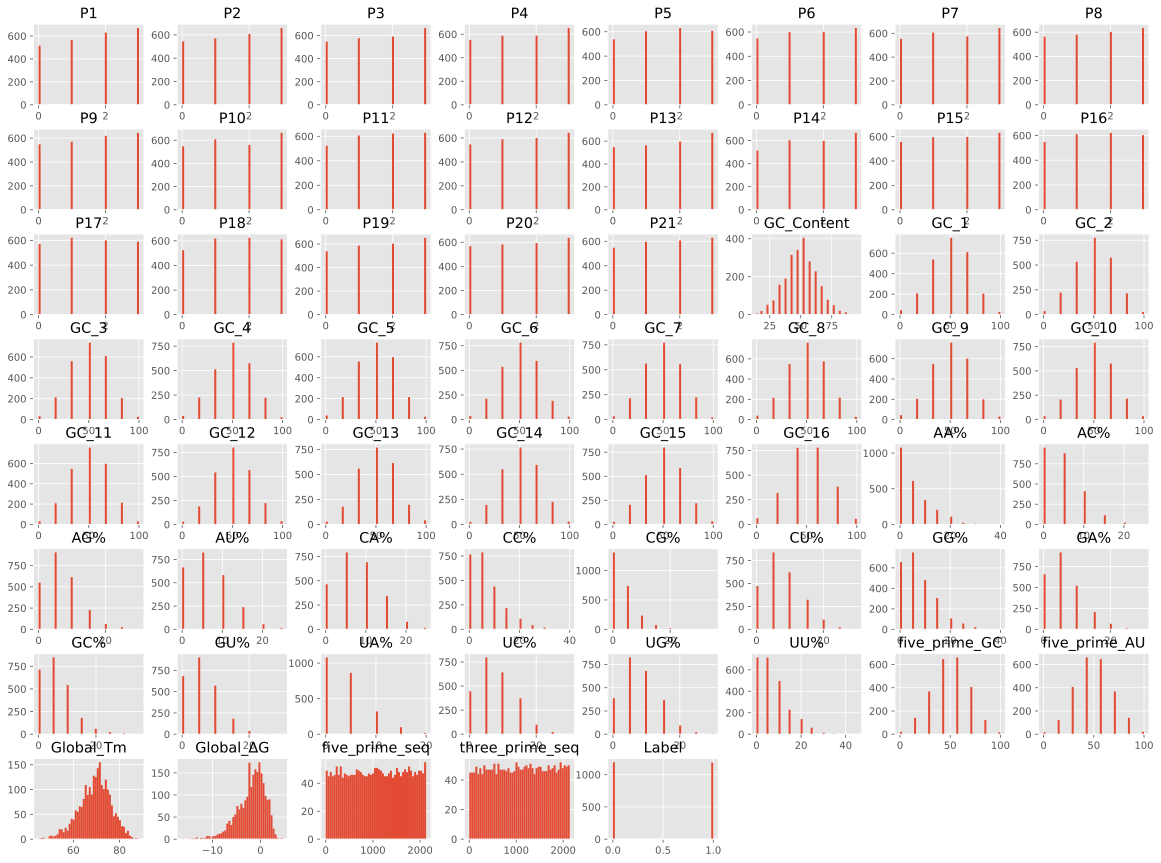

In [17]:
#Check for features distribution. This is a first step for understand which features are importand and which are not
%matplotlib inline
import matplotlib.pyplot as plt
dfLE.hist(bins=50, figsize=(20,15))
plt.show()

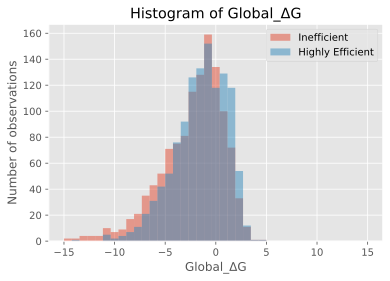

In [20]:
#Now we can also check for a specific feature's values within the two classes in order to check if there's variability and so, if the feature is relevant for classification puroposes
#We test now the global ΔG for example
# Histogram a feature for two different classes

# Set cell behavior to show output only from the last expression in cell
InteractiveShell.ast_node_interactivity = "last_expr"

feature_name = "Global_ΔG"
class_1_feat = dfLE[dfLE["Label"] == 0][feature_name]
class_2_feat = dfLE[dfLE["Label"] == 1][feature_name]

class_1_name = "Inefficient"
class_2_name = "Highly Efficient"

feature_axis_low = -15
feature_axis_high = 15
nbins = 40

bins = np.linspace(feature_axis_low, feature_axis_high, nbins)

plt.hist(class_1_feat, bins, alpha=0.5, label=class_1_name)
plt.hist(class_2_feat, bins, alpha=0.5, label=class_2_name)

plt.legend(loc='upper right')
plt.title(f"Histogram of {feature_name}")
plt.xlabel(f"{feature_name}")
plt.ylabel("Number of observations")
plt.show()

### PCA 

PCA(n_components=125)

                      PC0       PC1       PC2       PC3       PC4  ...  \
P1              -0.004082 -0.064553  0.009502  0.010918  0.024267  ...   
P2              -0.005868 -0.069928  0.034432  0.011143 -0.027211  ...   
P3               0.006113 -0.095986  0.008441  0.004960 -0.027164  ...   
P4               0.000211 -0.088677  0.021212 -0.003490  0.016752  ...   
P5               0.003584 -0.090834  0.025375  0.004342 -0.020198  ...   
...                   ...       ...       ...       ...       ...  ...   
Global_Tm        0.238063  0.010141  0.018009  0.009171 -0.010158  ...   
Global_ΔG       -0.119973 -0.048695 -0.016472  0.023448 -0.038395  ...   
five_prime_seq  -0.006079 -0.086514  0.018619  0.012091  0.012576  ...   
three_prime_seq  0.003158 -0.143696  0.023256  0.014864 -0.001486  ...   
Label           -0.058242 -0.031130 -0.018520 -0.055831 -0.105747  ...   

                        PC120         PC121         PC122         PC123  \
P1              -1.468294e-01  1.551

Text(0, 0.5, 'Explained Variance')

Text(0.5, 0, 'Components')

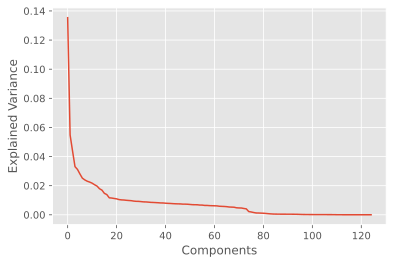

In [14]:
import pandas
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plot

#df = pandas.DataFrame(data=numpy.random.normal(0, 1, (20, 10)))

# You must normalize the data before applying the fit method
dfLE_normalized=(dfLE - dfLE.mean()) / dfLE.std()
pca = PCA(n_components=dfLE.shape[1])
pca.fit(dfLE_normalized)

# Reformat and view results
loadings = pandas.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(dfLE_normalized.columns))],
index=dfLE.columns)
print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

### Crossvalidation on Label Encoded Nuc-based Datasets for Strategy 2

In [15]:
# Split up dataset into 80% crossvalidation, 20% independent held-out test data
# Documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
dfLE_crossval, dfLE_test, class_crossvalLE, class_testLE = train_test_split(
    dfLE[[c for c in dfLE.columns if c != "Label"]], 
    dfLE["Label"], 
    test_size=0.20,
    stratify=dfLE["Label"],
    random_state=42  # sets seed to make the selection reproducible
)

# Check output to ensure split is as intended
dfLE_crossval.shape, dfLE_test.shape, class_crossvalLE.shape, class_testLE.shape

((1665, 124), (417, 124), (1665,), (417,))

In [16]:
# Set indices in ascending order starting from 0
#  as required by the sci-kit learn's StratifiedKFold function
dfLE_crossval.reset_index(inplace = True)
class_crossvalLE = class_crossvalLE.reset_index()

# If one wanted to recover the original indices:
# df_crossval.set_index("index")

In [17]:
# Prepare crossvalidation set
#   Documentation at https://scikit-learn.org/stable/modules/cross_validation.html#stratification
n_partitions = 5
skf = StratifiedKFold(n_splits = n_partitions)

# Split into crossvalidation sets (sets of indices in df_crossval and class_crossval)
#  and print out the resulting partition compositions for each partition as
#  train - [num_of_items_in_class_0 num_of_items_in_class_1] | test - [num_of_items_in_class_0 num_of_items_in_class_1]
y = class_crossvalLE["Label"]  # This line is needed for the np.bincount function to work
for train, test in skf.split(dfLE_crossval, y):
    print(f"train - {np.bincount(y[train])} | test - {np.bincount(y[test])}")

train - [668 664] | test - [166 167]
train - [667 665] | test - [167 166]
train - [667 665] | test - [167 166]
train - [667 665] | test - [167 166]
train - [667 665] | test - [167 166]


### Application of SVM Classifier Label Encoded Dataset
#### Linear kernel best so far (76%) - rbf(65%), sigmoid(45%)
##### I'm trying linear kernel with higher C for correctly separating as many instances as possible
##### With C=5 instead of 1, accuracy reduced by 3-6% over both training and testing
##### C=0.2 gave similar results so far with 2000 datapoints and linear kernel function with 79% and 74% accuracy for training and testing

In [18]:
%%capture
# Apply an SVM classifier
#  Documentation at https://scikit-learn.org/stable/modules/svm.html
#   and at https://scikit-learn.org/stable/modules/cross_validation.html
clf = svm.SVC(kernel='linear', C=0.2, random_state=42)  # define classifier
scoresLE = cross_validate(clf, dfLE_crossval, class_crossvalLE["Label"], cv=skf,
    scoring = ('accuracy', 'precision'),
    return_train_score=True)
# Other scikit-learn classifiers of possible interest:
#
# Logistic Regression with linear_model.LogisticRegression
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# Decision Tree based classification with tree.DecisionTreeClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#
# Neural Network based classification with neural_network.MLPClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html



In [19]:
# Examine results
scoresLE

# Nicer printing of specific performance metrics across partitions
scores_train_accLE = scoresLE["train_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_accLE]) + '%')

scores_train_accLE = scoresLE["test_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_accLE]) + '%')


{'fit_time': array([ 439.49774289,  537.93032336,  798.51033998,  472.27539992,
        1107.99408007]),
 'score_time': array([0.01334214, 0.01275182, 0.01223278, 0.0131371 , 0.01262808]),
 'test_accuracy': array([0.71471471, 0.75375375, 0.76576577, 0.77477477, 0.71771772]),
 'train_accuracy': array([0.80930931, 0.8033033 , 0.80105105, 0.79279279, 0.8033033 ]),
 'test_precision': array([0.73376623, 0.75609756, 0.78947368, 0.76608187, 0.7195122 ]),
 'train_precision': array([0.8125    , 0.8124031 , 0.80769231, 0.78986587, 0.80484115])}

80.93%, 80.33%, 80.11%, 79.28%, 80.33%
71.47%, 75.38%, 76.58%, 77.48%, 71.77%


In [20]:
# Prepare for final model training and evaluation
dfLE_crossval = dfLE_crossval.set_index("index") # remove explicit index column and reset indices to the original dataset indices
class_crossvalLE = class_crossvalLE.set_index("index") # remove explicit index column and reset indices to the original dataset indices

In [21]:
%%capture
# The Jupyter 'magic function' above supresses warnings in this cell
# If happy with model style and hyperparameters, train a model of this type on the entire crossvalidation dataset
clf_finalLE = svm.SVC(kernel='linear', C=0.2, random_state=42)  # define classifier

final_modelLE = clf_finalLE.fit(dfLE_crossval, class_crossvalLE) # train model

In [22]:
# Use the trained final model to predict class labels
pred_trainLE = final_modelLE.predict(dfLE_crossval) # predict class labels for the training set
pred_testLE = final_modelLE.predict(dfLE_test) # predict class labels for the independent test set

In [23]:
#  Documentation at https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
accuracy_score(pred_trainLE, class_crossvalLE) # accuracy in training

0.7903903903903904

In [24]:
confusion_matrix(pred_trainLE, class_crossvalLE) # confusion matrix for training

array([[669, 184],
       [165, 647]])

In [25]:
accuracy_score(pred_testLE, class_testLE) # accuracy in testing

0.7410071942446043

In [26]:
confusion_matrix(pred_testLE, class_testLE) # confusion matrix for testing

array([[160,  59],
       [ 49, 149]])

### Considerations about Strategy 2:
##### 1. Label transform each sequence into an index, and therefore the dataset dimension is kept as in the original one regarding size. This have solved the model overfitting problem that I had on the training dataset of Strategy 1.
##### 2. Still no significant differences detected between using protein or nucleotide sequences.

## Strategy 3 Start
### By applying MLP Neural Networks Classifier to the Strategy 1 (protein) Dataset I'm trying to overcome the overfitting problem that was consequent to the application of One Hot Encoding.

#### Import Packages for NN

In [27]:
from sklearn.neural_network import MLPClassifier

In [29]:
%%capture
# Apply an NN classifier with default 200 hidden layer sizes and the default alpha, which indiccates the strength of the L2 regularization term of 0.0001

NN_clf1 = MLPClassifier(hidden_layer_sizes=(200,), activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive')  # define classifier
scores1NN = cross_validate(NN_clf1, df2ohe_crossval, class_crossval2ohe["Response"], cv=skf,
    scoring = ('accuracy', 'precision'),
    return_train_score=True)

# Other scikit-learn classifiers of possible interest:
#
# Logistic Regression with linear_model.LogisticRegression
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# Decision Tree based classification with tree.DecisionTreeClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#
# Neural Network based classification with neural_network.MLPClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html



In [30]:
# Examine results
scores1NN

# Nicer printing of specific performance metrics across partitions
scores_train_acc1NN = scores1NN["train_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc1NN]) + '%')

scores_train_acc1NN = scores1NN["test_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc1NN]) + '%')

{'fit_time': array([73.31115127, 71.07973862, 68.29319096, 69.20294595, 72.78479862]),
 'score_time': array([0.11368132, 0.11804128, 0.1182549 , 0.11468601, 0.18641853]),
 'test_accuracy': array([0.7972973 , 0.80272109, 0.80272109, 0.76190476, 0.78911565]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.5       , 1.        , 0.66666667, 0.27272727, 0.33333333]),
 'train_precision': array([1., 1., 1., 1., 1.])}

100.0%, 100.0%, 100.0%, 100.0%, 100.0%
79.73%, 80.27%, 80.27%, 76.19%, 78.91%


#### As with the SVM+OneHot Encoding "experiment", the model overfits over the training dataset.
With the code below I'm trying to solve this problem by modifying model's paramethers

In [37]:
%%capture
# Apply an NN classifier with 50 hidden layer sizes and alpha=0.00001
# The rationale behind choosing a lower alpha, is that by reducing the strenght of the L2 regularization parameter, I'd expect to account for overfitting (lower strength = less model restrictions => tradeoff between accuracy and overfitting)
# Also, the same applies to the reduction of the hidden layer sizes, together with less complexity of the model
NN_clf2 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', alpha=0.000001, learning_rate='adaptive')  # define classifier
scores2NN = cross_validate(NN_clf2, df2ohe_crossval, class_crossval2ohe["Response"], cv=skf,
    scoring = ('accuracy', 'precision'),
    return_train_score=True)

In [38]:
# Examine results
scores2NN

# Nicer printing of specific performance metrics across partitions
scores_train_acc2NN = scores2NN["train_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc2NN]) + '%')

scores_train_acc2NN = scores2NN["test_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc2NN]) + '%')

{'fit_time': array([50.34199357, 46.19112444, 44.90162635, 43.71473122, 45.32056975]),
 'score_time': array([0.19313502, 0.11799765, 0.18282604, 0.20074439, 0.17665458]),
 'test_accuracy': array([0.80405405, 0.79591837, 0.78231293, 0.76870748, 0.81632653]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.53846154, 0.5       , 0.4       , 0.3       , 0.58823529]),
 'train_precision': array([1., 1., 1., 1., 1.])}

100.0%, 100.0%, 100.0%, 100.0%, 100.0%
80.41%, 79.59%, 78.23%, 76.87%, 81.63%


#### Even though the relaxation of the parameters, the model still overfits. The reason could be the that with OneHot Encoding we have a dataset with more features than datapoint 
##### Below, I'm going to analyze the final model only for the second NN that I run with less stringent parameters

In [ ]:
%%capture
# The Jupyter 'magic function' above supresses warnings in this cell
# If happy with model style and hyperparameters, train a model of this type on the entire crossvalidation dataset
#DF1
clf_final2NN = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', alpha=0.000001, learning_rate='adaptive')  # define classifier

final_model2NN = clf_final2NN.fit(df2ohe_crossval, class_crossval2ohe) # train model
# An irrelevant warning is produced because of the way sci-kit learn interprets a pandas series



In [ ]:
pred_train2NN = final_model2NN.predict(df2ohe_crossval) # predict class labels for the training set
pred_test2NN = final_model2NN.predict(df2ohe_test) # predict class labels for the independent test set

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


#### Evaluate final model performance

In [49]:
#DF2
accuracy_score(pred_train2NN, class_crossval2NN) # accuracy in training
accuracy_score(pred_test2NN, class_test2NN) # accuracy in testing

confusion_matrix(pred_train2NN, class_crossval2NN) # confusion matrix for training
confusion_matrix(pred_test2NN, class_test2NN) # confusion matrix for testing

1.0

0.7989130434782609

array([[586,   0],
       [  0, 150]])

array([[142,  32],
       [  5,   5]])

### Label Encoding SVM Test with Balanced Datapoints in Relation to the Class DIstribution

In [4]:
data = "data.csv"

In [68]:
#df1 is the dataframe for the Strategy 1
df1 = pd.read_csv(data)
df1

,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.30,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.60,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.20,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.70,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.50,572
...,...,...,...,...,...,...
995,996,0,NaN,CCCATTAGTCCTATTGARACTGTACCAGTAMAATTAAAGCCAGGAA...,3.15,354
996,997,0,NaN,CCCATYAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.50,50
997,998,0,NaN,CCCATYAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.10,369
998,999,0,NaN,CCTATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.37,127


In [69]:
#Rename columns
df1.columns = ["Patient_ID", "Response", "PR_Seq", "RT_Seq", "VL_T0", "CD4_T0"]

In [70]:
#Move the outcome (Response) column at the last column position of the dataset
df1 = df1[["Patient_ID", "PR_Seq", "RT_Seq", "VL_T0", "CD4_T0","Response"]]

In [71]:
#Columns check
df1.head()

,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
0,1,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145,0
1,2,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224,0
2,3,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017,0
3,4,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206,0
4,5,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572,0


In [72]:
#Check for NAs
pd.isna(df1)

,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
995,False,True,False,False,False,False
996,False,True,False,False,False,False
997,False,True,False,False,False,False
998,False,True,False,False,False,False


In [81]:
#Since there are some NAs, I deleted those rows 
df1 = df1.dropna()

In [154]:
df1_balanced0 = df1.query("Response == 0").sample(n=200)
df1_balanced1 = df1.query("Response == 1").sample(n=160)

df1_updated = pd.concat([df1_balanced0, df1_balanced1], axis=0)
df1_updated

,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
41,42,CCTCAAATCACTCTTTGGCAACGACCCCTYGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGATACTGTACCAGTAAAATTAAAGCCAGGAA...,4.5,14,0
203,204,CCTCAGATCACTCTTTGGCAACGACCCATCGTCACAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.7,197,0
200,201,CCTCAGATCACTCTTTGGCAACGACCCATCGTCACAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAGATTAAAGCCAGGAA...,3.4,555,0
821,822,CCTCAGATCACTYKTTGGCAACGACCCYKCGTCACAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGTTAAAACCAGGAA...,3.3,513,0
685,686,CCTCAGATCACTCTTTGGCAACGACCCMTCGTCCCAATAAGAATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAARATTAAAGCCAGGAA...,4.6,288,0
...,...,...,...,...,...,...
413,414,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.0,7,1
625,626,CCTCAGATCACTCTTTGGCAACGACCCCTTGTCACAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.1,85,1
472,473,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGRTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.3,87,1
620,621,CCTCAGATCACTCTTTGGCAACGACCCCTTGTCACAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,4.9,261,1


In [155]:
#Check for NAs
pd.isna(df1_updated)

,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
41,False,False,False,False,False,False
203,False,False,False,False,False,False
200,False,False,False,False,False,False
821,False,False,False,False,False,False
685,False,False,False,False,False,False
...,...,...,...,...,...,...
413,False,False,False,False,False,False
625,False,False,False,False,False,False
472,False,False,False,False,False,False
620,False,False,False,False,False,False


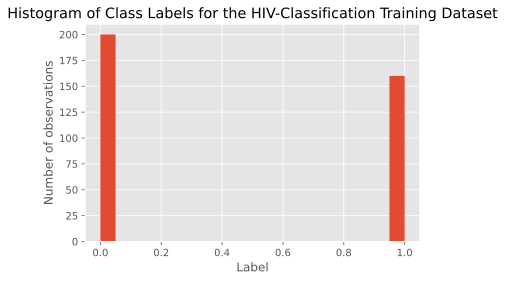

In [156]:
#Create an histogram for the original dataset to check positive and negative examples distribution
df1_updated["Response"].hist(bins=20);
#Add a title and axis labels
plt.title("Histogram of Class Labels for the HIV-Classification Training Dataset");
plt.xlabel("Label");
plt.ylabel("Number of observations");

### Let's create a new dataset with the HIV1 Protease (PR) and Reverse Transcriptase (RT) amino acids sequences instead of the nucleotide ones. This will be called df2 (Strategy 2).

In [157]:
#I hereby used the translate function from BioPython for converting the nucleotide sequences into amino acid sequences
df2 = pd.DataFrame([])
df2["CD4_T0"] = df1_updated["CD4_T0"]
df2["VL_T0"] = df1_updated["VL_T0"]
df2["Patient_ID"] = df1_updated["Patient_ID"]
df2["PR"] = df1_updated["PR_Seq"].apply(lambda x: str(Seq(x).translate()))
df2["RT"] =df1_updated["RT_Seq"].apply(lambda x: str(Seq(x).translate()))
df2["Response"] = df1_updated["Response"]
df2 = df2[["Patient_ID", "PR", "RT", "VL_T0", "CD4_T0","Response"]]

df2

/home/mandellc/.local/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


,Patient_ID,PR,RT,VL_T0,CD4_T0,Response
41,42,PQITLWQRPLVAIKVEGQLKEALLDTGADDTVLEDMNLPGKWKPKM...,PISPIDTVPVKLKPGMDGPKVKQWPLTEEKIKALIEICTXXEKEGK...,4.5,14,0
203,204,PQITLWQRPIVTIKIGGQLKEALIDTGADDTVLEEMNLPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTELEQDGK...,4.7,197,0
200,201,PQITLWQRPIVTIKIGGHLTEALLDTGADDTVLEEMNLPGRWKPKM...,PISPIETVPVRLKPGMDGPXVKQWPLTEEKIKALTEICTEMEKEGK...,3.4,555,0
821,822,PQITXWQRPXVTIKIGGQIKEALLDTGADDTVLEDMSLPGRWKPKM...,PISPIETVPVKLKPGMDGPRVKQWPLSEEKIKALIEICTEMEKEGK...,3.3,513,0
685,686,PQITLWQRPJVPIRIGGQLIEALLDTGADDTVLEEMNLPGRWKPKI...,PISPIETVPVXLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,4.6,288,0
...,...,...,...,...,...,...
413,414,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEDXNLPGKWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...,5.0,7,1
625,626,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,PISPIETVPVKLKPGMDGPRVKQWPLTEEKIKALVEICTEXEKEGK...,5.1,85,1
472,473,PQITLWQRPLVTIKXGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALXEICTELEKEGK...,5.3,87,1
620,621,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEDMXLPGKWKPKM...,PISPIETVPVKLKPGMDGPKVKQWPLPEEKIKALIEICTEMEKEGK...,4.9,261,1


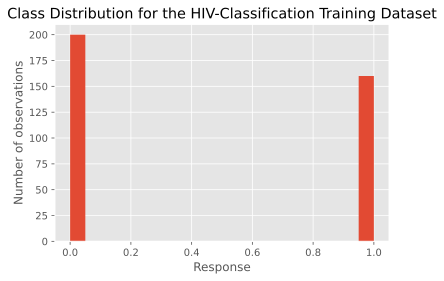

In [167]:
#Create an histogram for the original dataset to check positive and negative examples distribution
df2["Response"].hist(bins=20);
#Add a title and axis labels
plt.title("Class Distribution for the HIV-Classification Training Dataset");
plt.xlabel("Response");
plt.ylabel("Number of observations");

### Now that NaN rows have been excluded from the dataset, it is possible to proceed witht the One-Hot Encoding preprocessing step in order to transform nucleotide sequences in dummies
#### Import Packages

In [159]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import re

### Peform Label Encoding, for which data must be transformed into an integer machine-readable form.
#### In this case one can pre-process the data directly from the dataset (to my knowledge).

In [160]:
le = LabelEncoder()

In [161]:
df2['RT'] = le.fit_transform(df2['RT'].astype(str))
df2['PR'] = le.fit_transform(df2['PR'].astype(str))
df2

,Patient_ID,PR,RT,VL_T0,CD4_T0,Response
41,42,88,2,4.5,14,0
203,204,25,129,4.7,197,0
200,201,22,335,3.4,555,0
821,822,343,281,3.3,513,0
685,686,66,341,4.6,288,0
...,...,...,...,...,...,...
413,414,152,186,5.0,7,1
625,626,190,315,5.1,85,1
472,473,243,254,5.3,87,1
620,621,146,24,4.9,261,1


### Crossvalidation on Dataset for Strategy 1

In [162]:
# Split up dataset into 80% crossvalidation, 20% independent held-out test data
# Documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
df2_crossval, df2_test, class_crossval2, class_test2 = train_test_split(
    df2[[c for c in df2.columns if c != "Response"]], 
    df2["Response"], 
    test_size=0.20,
    stratify=df2["Response"],
    random_state=42  # sets seed to make the selection reproducible
)

# Check output to ensure split is as intended
df2_crossval.shape, df2_test.shape, class_crossval2.shape, class_test2.shape

((288, 5), (72, 5), (288,), (72,))

In [163]:
# Set indices in ascending order starting from 0
#  as required by the sci-kit learn's StratifiedKFold function
df2_crossval.reset_index(inplace = True)
class_crossval2 = class_crossval2.reset_index()

# If one wanted to recover the original indices:
# df_crossval.set_index("index")

In [ ]:
# Prepare crossvalidation set
#   Documentation at https://scikit-learn.org/stable/modules/cross_validation.html#stratification
n_partitions = 5
skf = StratifiedKFold(n_splits = n_partitions)

# Split into crossvalidation sets (sets of indices in df_crossval and class_crossval)
#  and print out the resulting partition compositions for each partition as
#  train - [num_of_items_in_class_0 num_of_items_in_class_1] | test - [num_of_items_in_class_0 num_of_items_in_class_1]
y = class_crossval1uu["Response"]  # This line is needed for the np.bincount function to work
for train, test in skf.split(df1uu_crossval, y):
    print(f"train - {np.bincount(y[train])} | test - {np.bincount(y[test])}")

train - [105  16] | test - [26  5]
train - [104  17] | test - [27  4]
train - [105  17] | test - [26  4]
train - [105  17] | test - [26  4]
train - [105  17] | test - [26  4]


In [165]:
# Prepare crossvalidation set
#   Documentation at https://scikit-learn.org/stable/modules/cross_validation.html#stratification
n_partitions = 5
skf = StratifiedKFold(n_splits = n_partitions)

# Split into crossvalidation sets (sets of indices in df_crossval and class_crossval)
#  and print out the resulting partition compositions for each partition as
#  train - [num_of_items_in_class_0 num_of_items_in_class_1] | test - [num_of_items_in_class_0 num_of_items_in_class_1]
y = class_crossval2["Response"]  # This line is needed for the np.bincount function to work
for train, test in skf.split(df2_crossval, y):
    print(f"train - {np.bincount(y[train])} | test - {np.bincount(y[test])}")

train - [128 102] | test - [32 26]
train - [128 102] | test - [32 26]
train - [128 102] | test - [32 26]
train - [128 103] | test - [32 25]
train - [128 103] | test - [32 25]


### Application of SVM Classifier to the Strategy 2 (AA) Dataset

In [166]:
%%capture
# Apply an SVM classifier
#  Documentation at https://scikit-learn.org/stable/modules/svm.html
#   and at https://scikit-learn.org/stable/modules/cross_validation.html
clf2 = svm.SVC(kernel='linear', C=1, random_state=42)  # define classifier
scores2 = cross_validate(clf2, df2_crossval, class_crossval2["Response"], cv=skf,
    scoring=('accuracy', 'precision'),
    return_train_score=True)

# Other scikit-learn classifiers of possible interest:
#
# Logistic Regression with linear_model.LogisticRegression
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#
# Decision Tree based classification with tree.DecisionTreeClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#
# Neural Network based classification with neural_network.MLPClassifier
#   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html



In [168]:
# Examine results
scores2

# Nicer printing of specific performance metrics across partitions
scores_train_acc2 = scores2["train_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc2]) + '%')

scores_train_acc2 = scores2["test_accuracy"]
print('%, '.join([str(round(100*x, 2)) for x in scores_train_acc2]) + '%')

{'fit_time': array([ 8.32062888, 12.62951469, 11.40500855,  3.71099257,  6.45411539]),
 'score_time': array([0.00366044, 0.00367403, 0.0035789 , 0.00352931, 0.00359797]),
 'test_accuracy': array([0.70689655, 0.84482759, 0.72413793, 0.77192982, 0.70175439]),
 'train_accuracy': array([0.75652174, 0.74347826, 0.76521739, 0.73593074, 0.77489177]),
 'test_precision': array([0.65517241, 0.81481481, 0.75      , 0.71428571, 0.61764706]),
 'train_precision': array([0.71296296, 0.69369369, 0.71428571, 0.6875    , 0.74757282])}

75.65%, 74.35%, 76.52%, 73.59%, 77.49%
70.69%, 84.48%, 72.41%, 77.19%, 70.18%


In [169]:
# Prepare for final model training and evaluation
df2_crossval = df2_crossval.set_index("index") # remove explicit index column and reset indices to the original dataset indices
class_crossval2 = class_crossval2.set_index("index") # remove explicit index column and reset indices to the original dataset indices


In [170]:
#DF2
clf_final2 = svm.SVC(kernel='linear', C=1, random_state=42)  # define classifier

final_model2 = clf_final2.fit(df2_crossval, class_crossval2) # train model

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [171]:
#DF2
pred_train2 = final_model2.predict(df2_crossval) # predict class labels for the training set
pred_test2 = final_model2.predict(df2_test) # predict class labels for the independent test set

### Evaluate final model performance

In [172]:
#DF2
accuracy_score(pred_train2, class_crossval2) # accuracy in training
accuracy_score(pred_test2, class_test2) # accuracy in testing

confusion_matrix(pred_train2, class_crossval2) # confusion matrix for training
confusion_matrix(pred_test2, class_test2) # confusion matrix for testing

0.7569444444444444

0.7083333333333334

array([[122,  32],
       [ 38,  96]])

array([[28,  9],
       [12, 23]])

### Why was this necessary?

#### I previously checked only the distribution of the numerical features (CD4_T0 and VL_T0), but actually the problem that influenced the most the True Negative Rate of the previous strategies was the unbalanced distribution of the datapoints across classes.
##### I'm coding the pre-check here since if I put it at the right place, the system gives me error during the encoding in the other strategies

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  2., 11.,  8., 22., 61., 39., 38.,
        44., 77., 44., 32., 76., 33., 31., 32., 52., 22., 13., 34., 21.,
         8.,  9., 14.,  7.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([2.        , 2.12820513, 2.25641026, 2.38461538, 2.51282051,
        2.64102564, 2.76923077, 2.8974359 , 3.02564103, 3.15384615,
        3.28205128, 3.41025641, 3.53846154, 3.66666667, 3.79487179,
        3.92307692, 4.05128205, 4.17948718, 4.30769231, 4.43589744,
        4.56410256, 4.69230769, 4.82051282, 4.94871795, 5.07692308,
        5.20512821, 5.33333333, 5.46153846, 5.58974359, 5.71794872,
        5.84615385, 5.97435897, 6.1025641 , 6.23076923, 6.35897436,
        6.48717949, 6.61538462, 6.74358974, 6.87179487, 7.        ]),
 <BarContainer object of 39 artists>)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  3.,
         0.,  5.,  5.,  7., 20., 10.,  9., 13., 26., 12.,  8., 17., 10.,
        11.,  8., 12.,  7.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([2.        , 2.12820513, 2.25641026, 2.38461538, 2.51282051,
        2.64102564, 2.76923077, 2.8974359 , 3.02564103, 3.15384615,
        3.28205128, 3.41025641, 3.53846154, 3.66666667, 3.79487179,
        3.92307692, 4.05128205, 4.17948718, 4.30769231, 4.43589744,
        4.56410256, 4.69230769, 4.82051282, 4.94871795, 5.07692308,
        5.20512821, 5.33333333, 5.46153846, 5.58974359, 5.71794872,
        5.84615385, 5.97435897, 6.1025641 , 6.23076923, 6.35897436,
        6.48717949, 6.61538462, 6.74358974, 6.87179487, 7.        ]),
 <BarContainer object of 39 artists>)

Text(0.5, 1.0, 'Histogram of VL_T0')

Text(0.5, 0, 'VL_T0')

Text(0, 0.5, 'Number of observations')

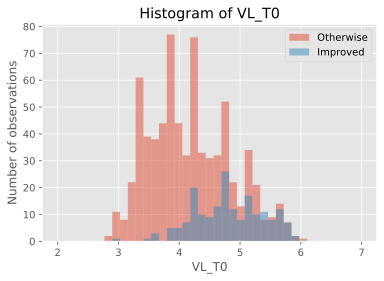

In [11]:
# Histogram a feature for two different classes

# Set cell behavior to show output only from the last expression in cell
InteractiveShell.ast_node_interactivity = "last_expr"

feature_name = "VL_T0"
class_1_feat = df1[df1["Response"] == 0][feature_name]
class_2_feat = df1[df1["Response"] == 1][feature_name]

class_1_name = "Otherwise"
class_2_name = "Improved"

feature_axis_low = 2
feature_axis_high = 7
nbins = 40

bins = np.linspace(feature_axis_low, feature_axis_high, nbins)

plt.hist(class_1_feat, bins, alpha=0.5, label=class_1_name)
plt.hist(class_2_feat, bins, alpha=0.5, label=class_2_name)

plt.legend(loc='upper right')
plt.title(f"Histogram of {feature_name}")
plt.xlabel(f"{feature_name}")
plt.ylabel("Number of observations")
plt.show()

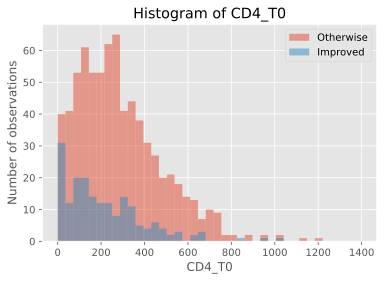

In [12]:
# Histogram a feature for two different classes

# Set cell behavior to show output only from the last expression in cell
InteractiveShell.ast_node_interactivity = "last_expr"

feature_name = "CD4_T0"
class_1_feat = df1[df1["Response"] == 0][feature_name]
class_2_feat = df1[df1["Response"] == 1][feature_name]

class_1_name = "Otherwise"
class_2_name = "Improved"

feature_axis_low = 0
feature_axis_high = 1400
nbins = 40

bins = np.linspace(feature_axis_low, feature_axis_high, nbins)

plt.hist(class_1_feat, bins, alpha=0.5, label=class_1_name)
plt.hist(class_2_feat, bins, alpha=0.5, label=class_2_name)

plt.legend(loc='upper right')
plt.title(f"Histogram of {feature_name}")
plt.xlabel(f"{feature_name}")
plt.ylabel("Number of observations")
plt.show()

In [13]:
df1

,Patient_ID,PR_Seq,RT_Seq,VL_T0,CD4_T0,Response
0,1,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145,0
1,2,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224,0
2,3,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017,0
3,4,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206,0
4,5,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572,0
...,...,...,...,...,...,...
915,916,GTCACAGTAAAAGTAGAGGGGCAACTAAAAGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,5.5,438,0
916,917,GTCGCAGTAAAGRTAGGGGGACAGCTAAAGGAAGCTCTATTAGATA...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,3.7,279,0
917,918,NCTCANATCACTCTTTGGCAACGACCCATCGTCACAATAAAGATAG...,CCCATTAGTCCTATTAAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.1,263,0
918,919,RTAAAGATRGGGGGACAACTAAAGGAAGCTTTATTAGATACAGGAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCGGGAA...,5.6,5,1


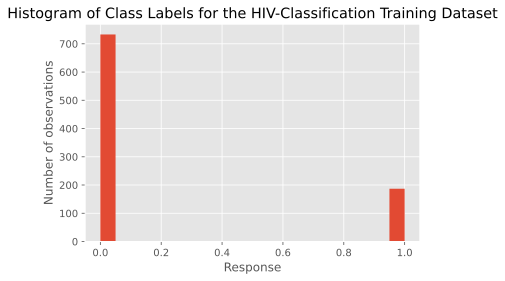

In [15]:
#Create an histogram for the original dataset to check positive and negative examples distribution
df1["Response"].hist(bins=20);
#Add a title and axis labels
plt.title("Histogram of Class Labels for the HIV-Classification Training Dataset");
plt.xlabel("Response");
plt.ylabel("Number of observations");

#### In the original dataset I had the positive examples amount that wasnearly 1/3 of the negative examples one

*Notebook Created By: Christian Mandelli, Oregon State University*